
# !! needs update !!

# Float vertical position control, energy diagnostics


---

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.

The work done by the piston is assumed to be given by:
$$
\begin{aligned}
W = \int_0^t c_{friction} \Big |(p_{water}-p_{float}) \; u \Big | dt
\end{aligned}
$$
where $u=\partial_tv$ is the time derivate of the adjusted volume, $c_f$ (uniteless, $>1$) accounts for friction.



In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *


WOA water profile at lon=-50, lat=40


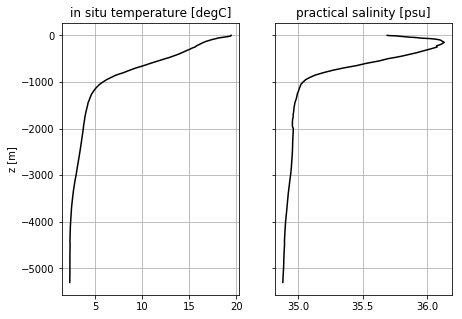

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
# compressible float

Note that a large piston course is necessary when the float needs to go deep

In [3]:
# Init now active control of the vertical position

#
z = np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')
f_c = f

# compute compressibility
gamma = compute_gamma(f.a,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -250m
iz = np.argmin(np.abs(z+400))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
#iz = np.argmin(np.abs(z+0.))
#vmax0 = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2

# set vmax such that the float is at equilibrium at 500m depth
iz = np.argmin(np.abs(z+400.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])

# use d_max to prescribe piston max course
dmax = .07*2

#
#f.init_piston(vol_min=vmin,vol_max=vmax,vol=vmax)
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

-56.1 g were added to the float in order to be at equilibrium at 403 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  2a    = 0.12 m      - float diameter
  m     = 5.60 kg     - float radius
  V     = 5.65e+03 cm^3   - float volume
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
Piston parameters and state: 
  2a    = 50.00 mm        - piston diameter
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 0.00 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  phi_max = 5026.55 deg     - maximum rotation
  phi_min = 0.00 deg     - minimum rotation
  d_max = 140.00 mm        - maximum piston displacement
  d_min = 0.00 mm        - minimum piston displacement
  vol_min = -274.89 cm^3    - m

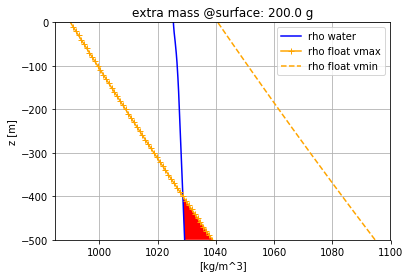

In [4]:
# show densities
plot_float_density(z, f, w)

---

## From the surface down to a target level

In [5]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600., -250., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=3.5e-01 m^2/s, fmin/m= -5.9e-01 m^2/s, wmax= 54.1 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 2.1e+03 cm/s, fmin/m= -3.5e+03 cm/s


In [6]:
# time step float with control
control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#
f.time_step(w,T=1800., dt_step=.1, dt_store=1., z=0., w=0., v=f.piston.vol_max,
            usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.585673780569076
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 113.8 Wh/day = 3414.5 Wh/30day


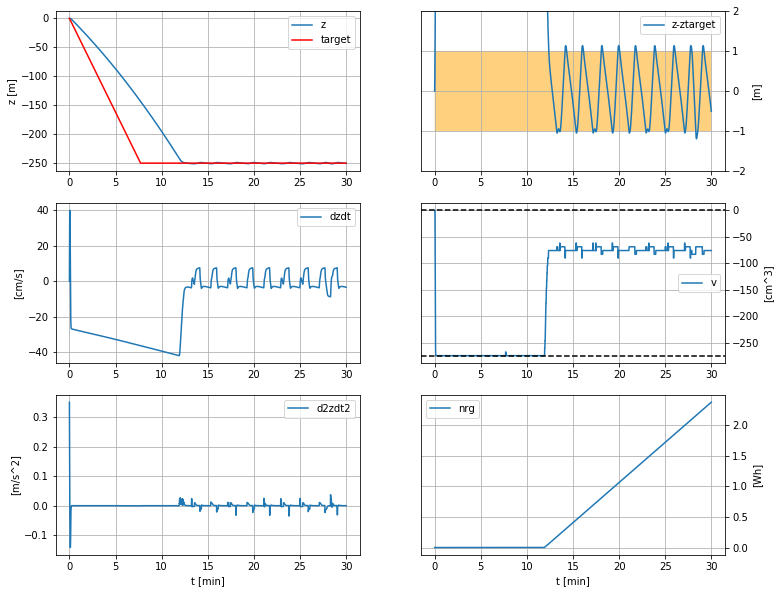

In [7]:
# plot log
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [8]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*10.)*t)
z_target = lambda t: -250.+t*0.

In [9]:
f.time_step(w, T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.585673780569076
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 185.3 Wh/day = 5559.2 Wh/30day


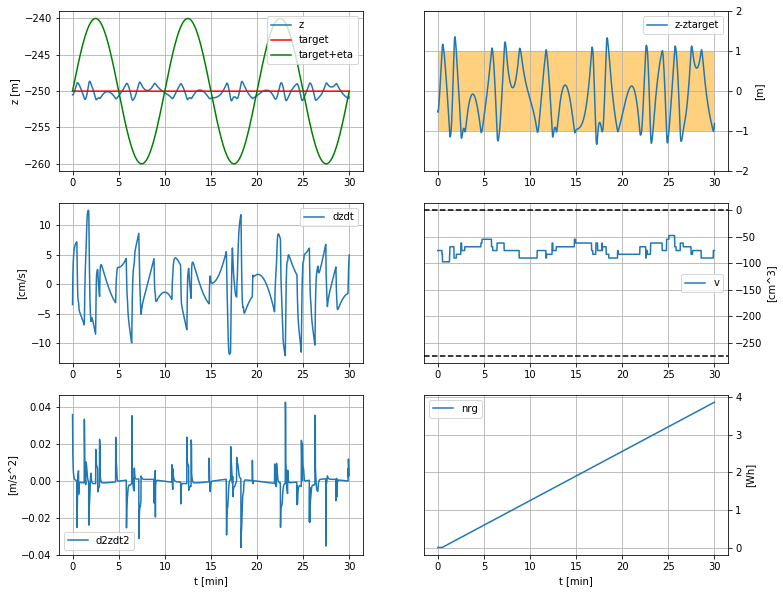

In [10]:
plot_log(f, z_target=z_target, eta=eta)

---

# Same float but with smaller compressibility

In [11]:

# store values from compressible float
vmin_fc = f_c.piston.vol_min
vmax_fc = f_c.piston.vol_max

print('vol_min compressible float: %.1f cm^3' %(vmin_fc*1e6))

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma = compute_gamma(f.a,.005,material='aluminium')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -250m
iz = np.argmin(np.abs(z+250))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float is neutral at the surface
iz = np.argmin(np.abs(z+0))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
#vmax = vmax_fc # not enough

# set vmin such that the float is neutral at 1000m depth
#iz = np.argmin(np.abs(z+1000))
#vmin = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
vmin = vmin_fc

# adjust vmax to be confortable at the surface - arbitrary !!!
#vmax = vmax + (vmax-vmin)
vmax += 50. * 1e-6 # units: m^3 ! 
#

f.init_piston(vol_min=vmin,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

# control
control['d3y_ctrl'] = afmax/f.m/1.

vol_min compressible float: -274.9 cm^3
Float compressibility = 3.042857e-06 /dbar 

152.6 g were added to the float in order to be at equilibrium at 252 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  2a    = 0.12 m      - float diameter
  m     = 5.81 kg     - float radius
  V     = 5.65e+03 cm^3   - float volume
  gamma = 3.04e-06 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
Piston parameters and state: 
  2a    = 50.00 mm        - piston diameter
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 58.58 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  phi_max = 6097.78 deg     - maximum rotation
  phi_min = 0.00 deg     - minimum rotation
  d_max = 169.84 mm        - maximum piston displacement
  d_min = 0.00 mm        - minimum piston dis

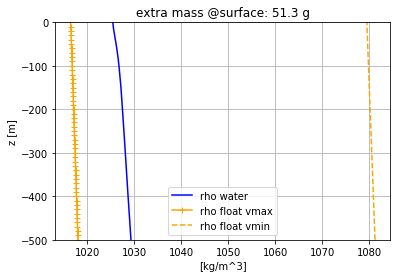

In [12]:
# show densities
plot_float_density(z, f, w)

In [13]:
#
f.time_step(w,T=1800., dt_step=.1, dt_store=1., z=0., w=0., v=f.piston.vol_max,
            usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.44913359135095304
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 108.8 Wh/day = 3265.5 Wh/30day


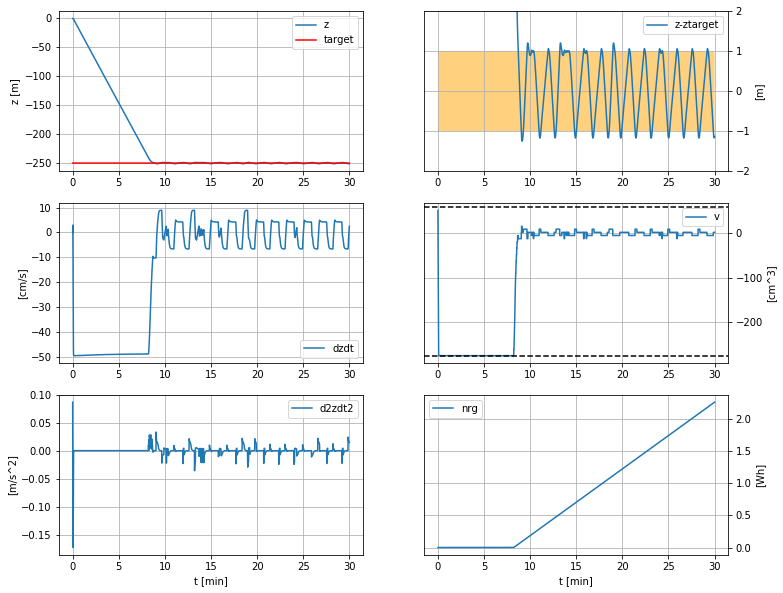

In [14]:
# plot log
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [15]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*10.)*t)
z_target = lambda t: -250.+t*0.

In [16]:
f.time_step(w, T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: tau = 10.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = sliding
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: d3y_ctrl = 0.44913359135095304
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 149.6 Wh/day = 4488.6 Wh/30day


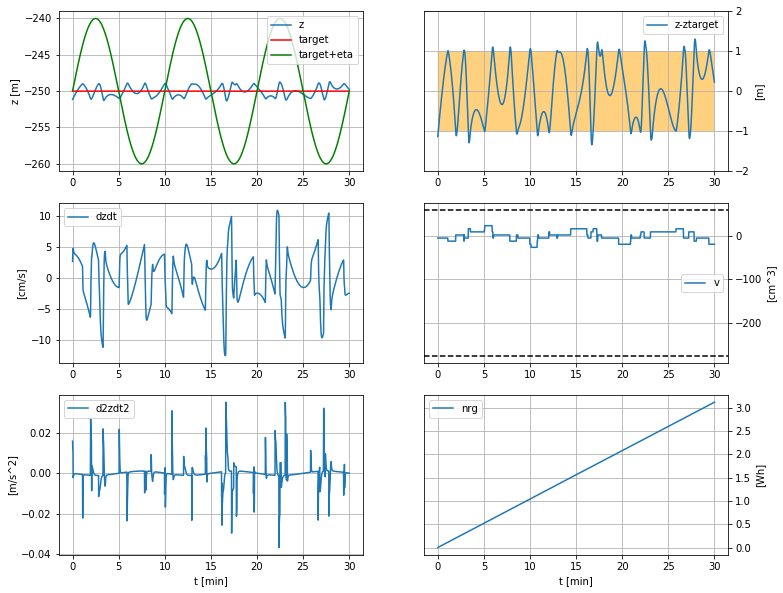

In [17]:
plot_log(f,z_target=z_target,eta=eta)